In [56]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

In [58]:
# load data
df = pd.read_csv('../../data/H2.csv')

In [59]:
# Handle missing values
df["Children"].fillna(0, inplace=True)  # Fill missing 'Children' with 0
df["Country"].fillna("Unknown", inplace=True)  # Fill missing 'Country' with 'Unknown'

# Drop rows where adults, babies and children are zero at the same time
df = df[(df["Adults"] != 0) | (df["Babies"] != 0) | (df["Children"] != 0)]

**Remove Directly Related Features:**

Features like `reservation_status`, `reservation_status_date` and `assigned_room_type` are directly related to the target variable is_canceled, and including them in the model would result in data leakage. Removing these features is essential to build a predictive model that can genuinely forecast cancellations, rather than retrospectively label them:

In [60]:
# Remove Directly Related columns with label
df = df.drop(
    ["ReservationStatus", "ReservationStatusDate", "AssignedRoomType"], axis=1
)

In [61]:
# Drop Duplicate rows
print(f"Total Number of Rows: {len(df)}")
print(f"Total Number of Rows without Duplicates: {len(df.drop_duplicates())}")

df = df.drop_duplicates()

Total Number of Rows: 79163
Total Number of Rows without Duplicates: 52427


In [62]:
# Remove Unimportant Variables
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_matrix['IsCanceled'].abs().sort_values(ascending=False)  

IsCanceled                     1.000000
LeadTime                       0.194041
TotalOfSpecialRequests         0.167560
RequiredCarParkingSpaces       0.126756
StaysInWeekNights              0.113899
BookingChanges                 0.091110
ADR                            0.082412
Adults                         0.080043
ArrivalDateYear                0.079534
IsRepeatedGuest                0.073888
StaysInWeekendNights           0.063109
PreviousBookingsNotCanceled    0.049054
PreviousCancellations          0.038171
Children                       0.034385
Babies                         0.021801
DaysInWaitingList              0.012109
ArrivalDateWeekNumber          0.006952
ArrivalDateDayOfMonth          0.003485
Name: IsCanceled, dtype: float64

In [63]:
df = df.drop(
    [
        "ArrivalDateDayOfMonth",
        "ArrivalDateWeekNumber",
    ],
    axis=1,
)

In [64]:
df.select_dtypes(include=['object', 'category']).columns

Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'DepositType', 'Agent',
       'Company', 'CustomerType'],
      dtype='object')

In [65]:
# Define a dictionary to map country codes to regions
country_to_region = {
    "PRT": "Europe",
    "GBR": "Europe",
    "ESP": "Europe",
    "IRL": "Europe",
    "NLD": "Europe",
    "RUS": "Europe",
    "FRA": "Europe",
    "DEU": "Europe",
    "ITA": "Europe",
    "BEL": "Europe",
    "CHE": "Europe",
    "USA": "North America",
    "CAN": "North America",
    "MEX": "North America",
    "CN": "Asia",
    "BRA": "South America",
    "ARG": "South America",
    "AUS": "Oceania",
    "Unknown": "Unknown",
}

# Map the country codes to regions
df["Region"] = df["Country"].map(country_to_region)

# Drop the Country column
df.drop(columns=["Country"], inplace=True)

df["Region"].value_counts()

Region
Europe           40928
South America     1722
North America     1466
Asia               488
Oceania            292
Unknown              3
Name: count, dtype: int64

In [66]:
# Remove blank spaces from the 'Agent' column
df['Agent'] = df['Agent'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Agent'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Agent'] = df['Agent'].astype(int)

df['Agent'].value_counts()

Agent
9      28582
0       5451
14      3329
7       3281
28      1482
       ...  
388        1
480        1
464        1
476        1
449        1
Name: count, Length: 224, dtype: int64

In [67]:
# Remove blank spaces from the 'Agent' column
df['Company'] = df['Company'].str.strip()

# Replace 'NULL' values in the 'Agent' column with 0
df['Company'].replace('NULL', 0, inplace=True)

# Convert the 'Agent' column to integer
df['Company'] = df['Company'].astype(int)

df['Company'].value_counts()

Company
0      49722
40       841
45       230
153      205
219      130
       ...  
481        1
494        1
491        1
421        1
497        1
Name: count, Length: 204, dtype: int64

In [68]:
from sklearn.model_selection import train_test_split

# Split data to features and target
X = df.drop("IsCanceled", axis=1)
y = df["IsCanceled"]

# Stratified splitting into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42,
    shuffle=True
)

# Check the resulting split sizes and class distribution in both sets
train_size = X_train.shape[0]
test_size = X_test.shape[0]
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

train_size, test_size, train_class_distribution, test_class_distribution

(41941,
 10486,
 IsCanceled
 0    0.698004
 1    0.301996
 Name: proportion, dtype: float64,
 IsCanceled
 0    0.697978
 1    0.302022
 Name: proportion, dtype: float64)

In [69]:
# Categoric and Numeric features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

imp_num = SimpleImputer(strategy='median')
imp_cat = SimpleImputer(strategy='most_frequent')

# Fit and transform the training data
X_train_num = imp_num.fit_transform(X_train[numerical_features])
X_train_cat = imp_cat.fit_transform(X_train[categorical_features])

# Transform the test data
X_test_num = imp_num.transform(X_test[numerical_features])
X_test_cat = imp_cat.transform(X_test[categorical_features])

# Convert the arrays back to dataframes
X_train_num = pd.DataFrame(X_train_num, columns=numerical_features)
X_train_cat = pd.DataFrame(X_train_cat, columns=categorical_features)

X_test_num = pd.DataFrame(X_test_num, columns=numerical_features)
X_test_cat = pd.DataFrame(X_test_cat, columns=categorical_features)

# Combine the numeric and categorical features
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [70]:
X_train.shape, X_test.shape

((41941, 25), (10486, 25))

In [71]:
# OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the training data
X_train_cat_encoded = encoder.fit_transform(X_train[categorical_features])

# Transform the test data
X_test_cat_encoded = encoder.transform(X_test[categorical_features])

In [72]:
X_train_cat_encoded.shape, X_train[categorical_features].shape

((41941, 49), (41941, 8))

In [73]:
len(encoder.get_feature_names_out())

49

In [74]:
type(X_train_cat_encoded)

scipy.sparse._csr.csr_matrix

In [75]:
# Convert csr_matrix to numpy array
X_train_cat_encoded = X_train_cat_encoded.toarray()
X_test_cat_encoded = X_test_cat_encoded.toarray()

# Convert the arrays back to dataframes
X_train_cat_encoded = pd.DataFrame(
    X_train_cat_encoded, columns=encoder.get_feature_names_out()
)
X_test_cat_encoded = pd.DataFrame(
    X_test_cat_encoded, columns=encoder.get_feature_names_out()
)

# Combine the numeric and categorical features
X_train = pd.concat([X_train_num, X_train_cat_encoded], axis=1)
X_test = pd.concat([X_test_num, X_test_cat_encoded], axis=1)

In [76]:
# oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# New Class Distribution
from collections import Counter
print(f"Class Distribution after SMOTE : {Counter(y_train)}")


Class Distribution after SMOTE : Counter({0: 29275, 1: 29275})


In [77]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((58550, 66), (58550,), (10486, 66), (10486,))

In [78]:
# Instantiate the classifier
rf = RandomForestClassifier(random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict the labels
y_pred = rf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7909593744039672

In [79]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[6516,  803],
       [1389, 1778]])

In [80]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      7319
           1       0.69      0.56      0.62      3167

    accuracy                           0.79     10486
   macro avg       0.76      0.73      0.74     10486
weighted avg       0.78      0.79      0.78     10486



In [81]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

np.float64(0.7258500730372347)

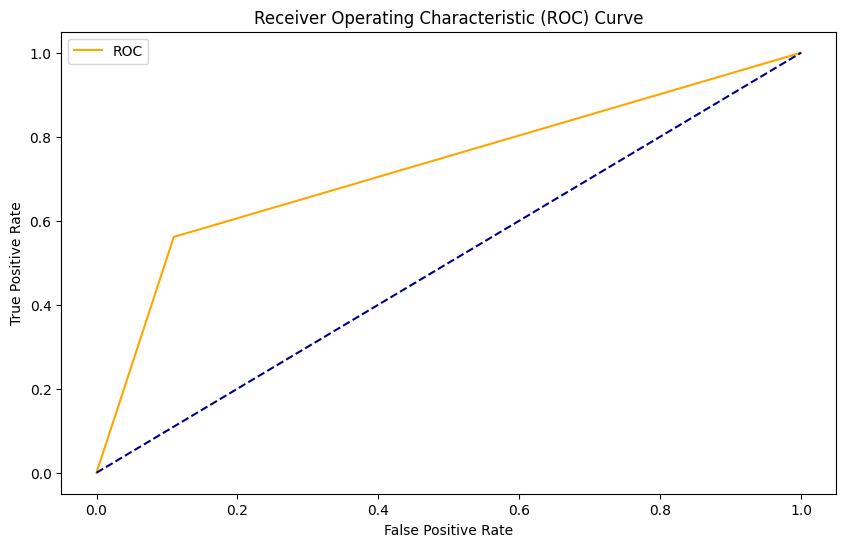

In [82]:
# Calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [83]:
# Perform 5-fold cross validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
cv_scores

array([0.71955594, 0.70956447, 0.9030743 , 0.93808711, 0.93509821])

In [84]:
# Calculate the mean accuracy
cv_mean = cv_scores.mean()
cv_mean

np.float64(0.841076003415884)

In [85]:
# Calculate the standard deviation of accuracy
cv_std = cv_scores.std()
cv_std

np.float64(0.10407451745739812)

In [86]:
# Define the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [87]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict the labels
y_pred = best_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8025939347701697

In [88]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[6628,  691],
       [1379, 1788]])

In [89]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      7319
           1       0.72      0.56      0.63      3167

    accuracy                           0.80     10486
   macro avg       0.77      0.74      0.75     10486
weighted avg       0.80      0.80      0.79     10486



In [90]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

np.float64(0.735080172704295)

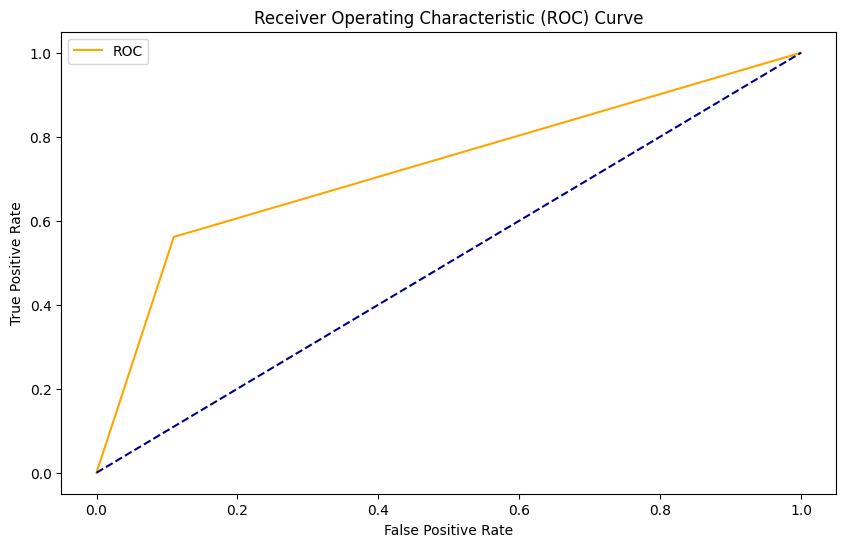

In [91]:
# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [92]:
# Perform 5-fold cross validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
cv_scores

array([0.73279249, 0.72245944, 0.90836892, 0.94150299, 0.93953886])

In [93]:
# Calculate the mean accuracy
cv_mean = cv_scores.mean()

# Calculate the standard deviation of accuracy
cv_std = cv_scores.std()

cv_mean, cv_std

(np.float64(0.8489325362937661), np.float64(0.09979522381316641))